# Clustering using K-Means
- This tutorial covers developing a clustering model using K-Means methodology.
- [Credit Card Dataset for Clustering](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata.html) dataset from Kaggle website has been used for model development and analysis.
- Different machine learning techniques such as : **PCA, Silhoutte plotting, K-means analysis etc** were applied to develop right number of clusters and relevant business strategy.

In [1]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas_profiling
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import gridspec
from yellowbrick.cluster import SilhouetteVisualizer
from scipy import stats
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

### 1. Defining utility functions to be used later

In [2]:
# function to log-normalize input data

def log_norm(df):
    tmp = df.copy()
    for column in tmp.columns:
        if column != 'CUST_ID':
          tmp[column] = np.log(1 + tmp[column])
    return tmp

In [3]:
# function to see distribution of a dataframe's columns through box-plots

def box_plot(odf):
    tmp = odf.copy()
    features = list(tmp.columns)
    features.remove('CUST_ID')
    len_features = len(features) 
    if (len_features % 4) == 0:
        plt_r = int(len_features/4)
    else:
        plt_r = (int(len_features/4))+1
  
    fig, axes = plt.subplots(plt_r, 4, figsize=(15, 15))
    plt.tight_layout()
    for i, col in enumerate(features):
        ax = sns.boxplot(y=tmp[col], ax=axes.flatten()[i])
        ax.set_ylabel(col, rotation=90, fontsize=10)
    plt.show()

In [4]:
# function to determine optimal clusters through elbow-plot. Clustering Technique used:K-Means

def elbow_plot(odf):
    tmp = odf.copy()
    wcsos = []
    for k in range(2,11):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(tmp.iloc[:,1:]) 
        wcsos.append(kmeans.inertia_)
    
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(range(2,11), wcsos, linewidth=1.5, color='green', marker='X')
    plt.xlabel('K: Number of Clusters')
    plt.xticks(np.arange(1,12,1))
    plt.ylabel('Within Cluster Sum Of Squares')
    for i, v in enumerate(wcsos):
        plt.text(i+2.2, v, '%.0e' %v, ha='center')
        
    plt.show()

In [5]:
# function to determine optimal clusters through Silhoutte-plot. Clustering Technique used:K-Means

def silhoutte_plot(odf):
    tmp = odf.copy()
    range_n_clusters = range(2, 9)
    
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        preds = clusterer.fit_predict(tmp)
        centers = clusterer.cluster_centers_
        score = np.round((silhouette_score(tmp, preds)),4)
        print('For {} clusters, Silhouette score is {}'.format(n_clusters, score))
        visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')
        visualizer.fit(tmp)
        visualizer.show()

In [6]:
# function to assign clusters to a dataframe : Clustering Technique used:K-Means

def assign_cluster(df, columns, n_cluster):
    odf = df.copy()
    n_centers = KMeans(n_clusters=n_cluster, random_state=42) #3 or 6 clusters
    n_centers.fit(odf[columns])
    tmp = pd.concat([odf, pd.DataFrame({'Cluster':n_centers.labels_}, index=odf.index)], axis=1)
    return tmp

In [7]:
# function to determine statsistical values of the assigned clusters

def cluster_statistics(odf):
    tmp1 = odf.copy()
    for c in tmp1.columns[1:]: 
        grid = sns.FacetGrid(tmp1, col='Cluster', height=3, aspect=1.3)
        grid.map(plt.hist, c, bins=20, edgecolor='k')
        grid.set_xticklabels(rotation=40)
        
    # Dataset to count total observations in each cluster
    tmp2 = pd.DataFrame(tmp1['Cluster'].value_counts().sort_index())
    tmp2 = tmp2.rename(columns = {'Cluster':'Count'})
         
    def std(x): 
        return np.std(x)
    
    # dataset with summary statsitsics for each cluster
    cluster_stats = tmp1.groupby(['Cluster'], as_index=False).agg(['mean', std, 'min', 'max'])
    cluster_stats = pd.concat([cluster_stats, tmp2],  axis=1)
    return cluster_stats   

In [8]:
# function to get a visual of clusters in two dimensions

def plot_2d(df, labels):
    tmp = df.copy()
    distance = 1 - cosine_similarity(tmp)
    pca = PCA(n_components=2, random_state=42)
    df_PCA = pca.fit_transform(distance)
    PCA_1 =  np.ravel(df_PCA[:, 0])
    PCA_2 = np.ravel(df_PCA[:, 1])
    labels = np.ravel(labels)
    df_pt=pd.DataFrame({'PCA_1': PCA_1, 'PCA_2': PCA_2, 'Cluster': labels})
    
    plt.subplots(figsize=(10, 8))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='Cluster', data=df_pt, palette=plt.cm.tab20,
                    s=100, alpha=.5, legend='full', edgecolor='k', linewidth=1.2)
    plt.show()

In [9]:
# function to get a visual of clusters in three dimensions

def plot_3d(df, labels):
    tmp = df.copy()
    distance = 1 - cosine_similarity(tmp)
    pca = PCA(n_components=3, random_state=42)
    df_PCA = pca.fit_transform(distance)
    PCA_1 =  np.ravel(df_PCA[:, 0])
    PCA_2 = np.ravel(df_PCA[:, 1])
    PCA_3 = np.ravel(df_PCA[:, 2])
    labels = np.ravel(labels)
    u_labels = sorted(np.unique(labels))
    df_pt=pd.DataFrame({'PCA_1': PCA_1, 'PCA_2': PCA_2, 'PCA_3': PCA_3, 'Cluster': labels})    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for l in u_labels:
        ax.scatter(df_pt.PCA_1[df_pt.Cluster == l],
                   df_pt.PCA_2[df_pt.Cluster == l],
                   df_pt.PCA_3[df_pt.Cluster == l],
                   label = l, s=60)
        ax.view_init(30, 185)
        plt.xlabel('PCA_1')
        plt.ylabel('PCA_2')
        ax.set_zlabel('PCA_3')
     
    ax.legend(loc='center left', fontsize=10, title='Cluster')
    plt.show()

### 1. Data import and exploratory analysis

In [10]:
df_credit_cards = pd.read_csv('/content/ccd.csv')
display(df_credit_cards.head())
print('Dataset dimensions : {}'.format(df_credit_cards.shape))

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Dataset dimensions : (8950, 18)


In [11]:
df1 = df_credit_cards.copy()

#checking missing values in all the columns
df1.isnull().sum().sort_values(ascending=False)

MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
CUST_ID                               0
BALANCE                               0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
CASH_ADVANCE_FREQUENCY                0
PURCHASES_INSTALLMENTS_FREQUENCY      0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                      0
PURCHASES                             0
BALANCE_FREQUENCY                     0
TENURE                                0
dtype: int64

In [12]:
# dropping all the rows with missing values
df1 = df1.dropna(axis=0)

# dropping the columns ONEOFF_PURCHASES
df1 = df1.drop(['ONEOFF_PURCHASES'], axis=1)

# checking missing values in all the remaining columns
df1.isnull().sum().sort_values(ascending=False)

CUST_ID                             0
CASH_ADVANCE_FREQUENCY              0
PRC_FULL_PAYMENT                    0
MINIMUM_PAYMENTS                    0
PAYMENTS                            0
CREDIT_LIMIT                        0
PURCHASES_TRX                       0
CASH_ADVANCE_TRX                    0
PURCHASES_INSTALLMENTS_FREQUENCY    0
BALANCE                             0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_FREQUENCY                 0
CASH_ADVANCE                        0
INSTALLMENTS_PURCHASES              0
PURCHASES                           0
BALANCE_FREQUENCY                   0
TENURE                              0
dtype: int64

In [13]:
# collecting all column names from dataset with significant variables
all_analysis_columns = list(df1.columns)
# dropping ID column from the column names list
all_analysis_columns.remove('CUST_ID')

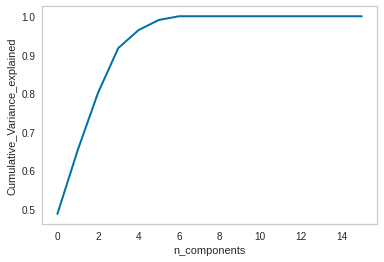

n_components= 0,   variance=48.680000
n_components= 1,   variance=65.230000
n_components= 2,   variance=80.100000
n_components= 3,   variance=91.740000
n_components= 4,   variance=96.410000
n_components= 5,   variance=99.040000
n_components= 6,   variance=100.000000
n_components= 7,   variance=100.000000
n_components= 8,   variance=100.000000
n_components= 9,   variance=100.000000
n_components= 10,   variance=100.000000
n_components= 11,   variance=100.000000
n_components= 12,   variance=100.000000
n_components= 13,   variance=100.000000
n_components= 14,   variance=100.000000
n_components= 15,   variance=100.000000


In [14]:
# Performing PCA analysis on all columns to select the significant variables
pca=PCA(random_state=21)  
pca.n_components=df1[all_analysis_columns].shape[1] 
pca_data=pca.fit_transform(df1[all_analysis_columns])

percentage_var_explained = pca.explained_variance_ratio_  
cumulative_var_explained = np.cumsum(percentage_var_explained)

# plot the variability explained by Principal Components
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cumulative_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)  
for index,var in enumerate(exp_var_cumsum):  
    print('n_components= %d,   variance=%f' %(index,np.round(var,3)))

In [15]:
# selecting Component 0 to 5 as they explain 99% variability
# creating a dataset to determine Features corresponding to top 5 PCA Components
pd.set_option('display.float_format', lambda x : '%.3f' % x)

pcd = (abs(pca.components_))
feautre_df = pd.DataFrame({'C1': pcd[:, 0], 'C2': pcd[:, 1], 'C3': pcd[:, 2],
                           'C4': pcd[:, 3], 'C5': pcd[:, 4], 'C6': pcd[:, 5]})
print(feautre_df)

#from the results PCA components have these relevant Features 
#C1 : 4,5,2,0
#C2 : 13
#C3 : 1,5,3,4,6
#C4 : 6
#C5 : 3,5
#C6 : 10,15

      C1    C2    C3    C4    C5    C6
0  0.308 0.000 0.271 0.080 0.237 0.000
1  0.270 0.000 0.473 0.131 0.043 0.000
2  0.314 0.000 0.144 0.035 0.359 0.000
3  0.061 0.000 0.437 0.169 0.659 0.000
4  0.770 0.000 0.390 0.120 0.013 0.000
5  0.369 0.000 0.469 0.242 0.613 0.000
6  0.031 0.000 0.345 0.935 0.039 0.000
7  0.001 0.001 0.006 0.008 0.000 0.008
8  0.000 0.002 0.000 0.000 0.002 0.004
9  0.000 0.015 0.000 0.000 0.000 0.006
10 0.000 0.120 0.000 0.000 0.000 0.706
11 0.000 0.119 0.000 0.000 0.000 0.022
12 0.000 0.237 0.000 0.000 0.000 0.242
13 0.000 0.948 0.000 0.000 0.000 0.143
14 0.000 0.129 0.000 0.000 0.000 0.051
15 0.000 0.024 0.000 0.000 0.000 0.647


In [16]:
# creating 2 new dataframes : One with all columns, one with significant columns from PCA
df_all_columns = df1.copy()
df_selected_columns = df_all_columns.iloc[:, [0,1,2,3,4,5,6,7,11,14,16]].copy()
# collecting all column names from dataset with significant variables
selected_analysis_columns = list(df_selected_columns.columns)
# dropping ID column from the column names list
selected_analysis_columns.remove('CUST_ID')

In [17]:
# log-normalising the df_all_columns and df_selected_columns, using previously defined function

df_all_columns_log = log_norm(df_all_columns)
df_selected_columns_log = log_norm(df_selected_columns)

In [18]:
# So in total we have 4 dataframes :

# dataframe with all columns
display(df_all_columns.head())

# dataframe with log normal of all columns
display(df_all_columns_log.head())

# dataframe with all columns
display(df_selected_columns.head())

# dataframe with log normal of all columns
display(df_selected_columns_log.head())

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.901,0.818,95.400,95.400,0.000,0.167,0.000,0.083,0.000,0,2,1000.000,201.802,139.510,0.000,12
1,C10002,3202.467,0.909,0.000,0.000,6442.945,0.000,0.000,0.000,0.250,4,0,7000.000,4103.033,1072.340,0.222,12
2,C10003,2495.149,1.000,773.170,0.000,0.000,1.000,1.000,0.000,0.000,0,12,7500.000,622.067,627.285,0.000,12
4,C10005,817.714,1.000,16.000,0.000,0.000,0.083,0.083,0.000,0.000,0,1,1200.000,678.335,244.791,0.000,12
5,C10006,1809.829,1.000,1333.280,1333.280,0.000,0.667,0.000,0.583,0.000,0,8,1800.000,1400.058,2407.246,0.000,12


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,3.735,0.598,4.569,4.569,0.000,0.154,0.000,0.080,0.000,0.000,1.099,6.909,5.312,4.945,0.000,2.565
1,C10002,8.072,0.647,0.000,0.000,8.771,0.000,0.000,0.000,0.223,1.609,0.000,8.854,8.320,6.979,0.201,2.565
2,C10003,7.823,0.693,6.652,0.000,0.000,0.693,0.693,0.000,0.000,0.000,2.565,8.923,6.435,6.443,0.000,2.565
4,C10005,6.708,0.693,2.833,0.000,0.000,0.080,0.080,0.000,0.000,0.000,0.693,7.091,6.521,5.504,0.000,2.565
5,C10006,7.502,0.693,7.196,7.196,0.000,0.511,0.000,0.460,0.000,0.000,2.197,7.496,7.245,7.787,0.000,2.565


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,MINIMUM_PAYMENTS,TENURE
0,C10001,40.901,0.818,95.400,95.400,0.000,0.167,0.000,2,139.510,12
1,C10002,3202.467,0.909,0.000,0.000,6442.945,0.000,0.000,0,1072.340,12
2,C10003,2495.149,1.000,773.170,0.000,0.000,1.000,1.000,12,627.285,12
4,C10005,817.714,1.000,16.000,0.000,0.000,0.083,0.083,1,244.791,12
5,C10006,1809.829,1.000,1333.280,1333.280,0.000,0.667,0.000,8,2407.246,12


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,MINIMUM_PAYMENTS,TENURE
0,C10001,3.735,0.598,4.569,4.569,0.000,0.154,0.000,1.099,4.945,2.565
1,C10002,8.072,0.647,0.000,0.000,8.771,0.000,0.000,0.000,6.979,2.565
2,C10003,7.823,0.693,6.652,0.000,0.000,0.693,0.693,2.565,6.443,2.565
4,C10005,6.708,0.693,2.833,0.000,0.000,0.080,0.080,0.693,5.504,2.565
5,C10006,7.502,0.693,7.196,7.196,0.000,0.511,0.000,2.197,7.787,2.565


### 3.1 Analysis on the Original Dataset

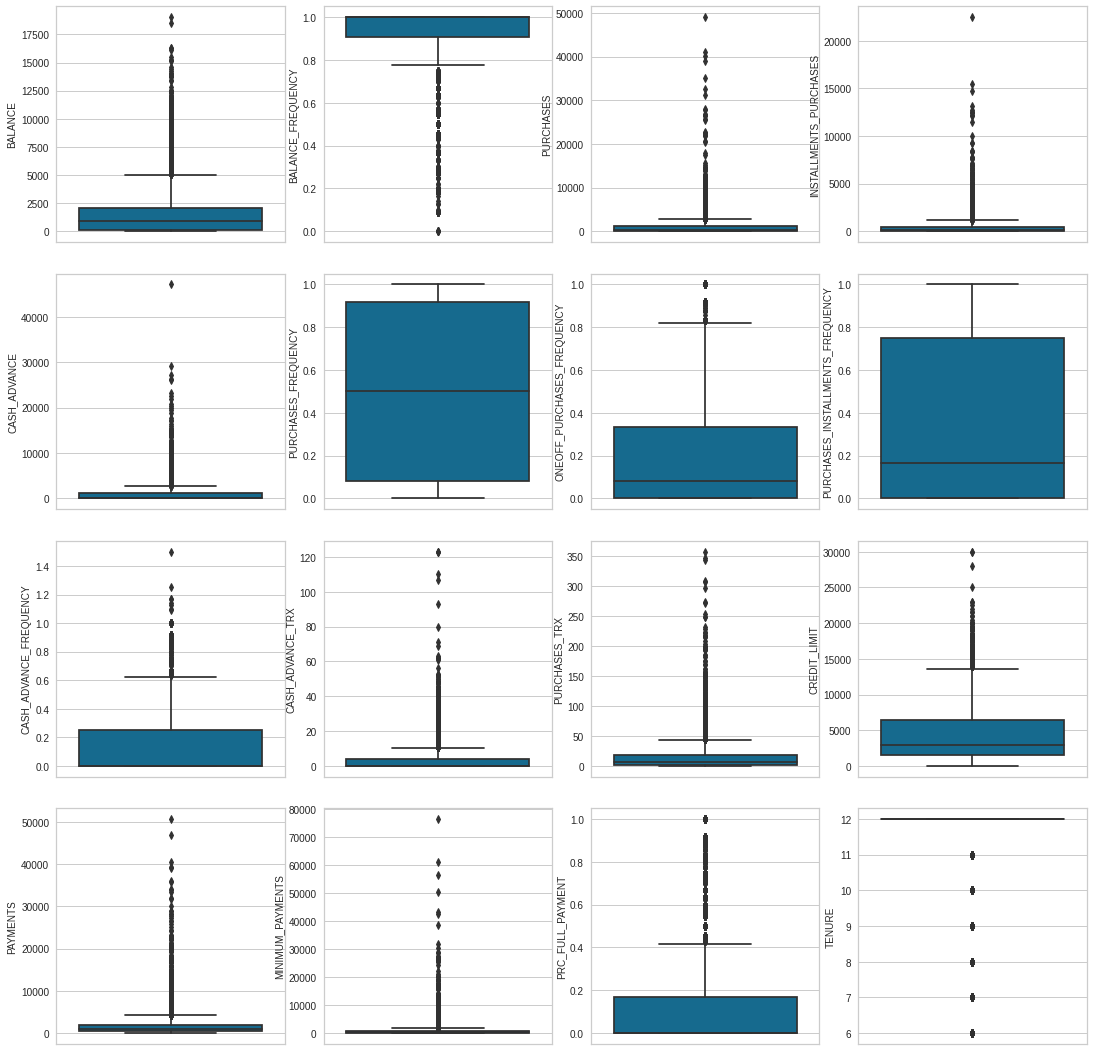

In [19]:
box_plot(df_all_columns)
# It can be observed that a lot of variabels have a skewed distribution.
# This might affect clustering analysis

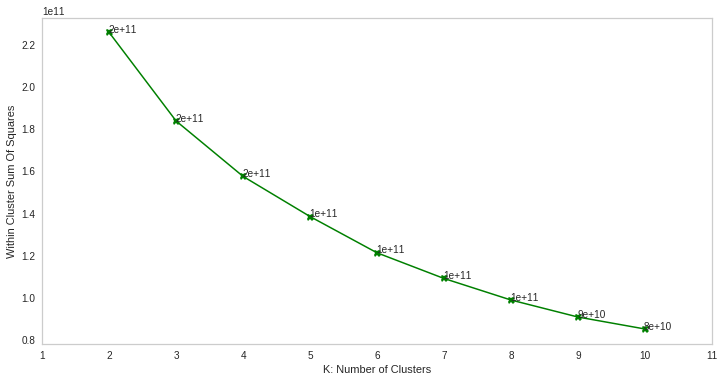

In [20]:
# creating elbow plot using K-means scoring : no distinct 'elbow-point' observed
elbow_plot(df_all_columns[all_analysis_columns])

For 2 clusters, Silhouette score is 0.5128


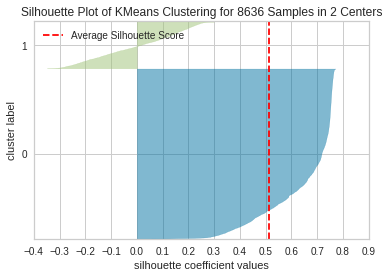

For 3 clusters, Silhouette score is 0.4561


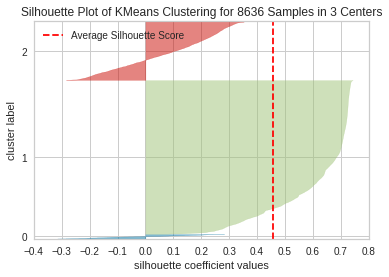

For 4 clusters, Silhouette score is 0.4562


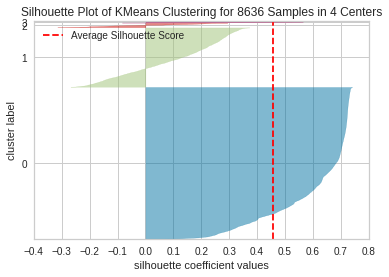

For 5 clusters, Silhouette score is 0.3832


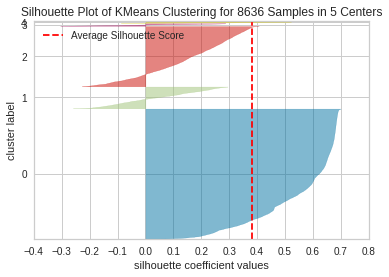

For 6 clusters, Silhouette score is 0.3809


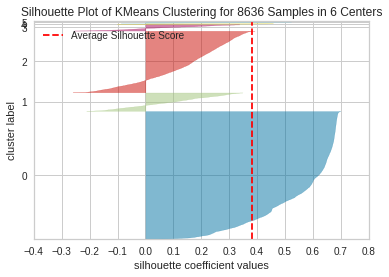

For 7 clusters, Silhouette score is 0.377


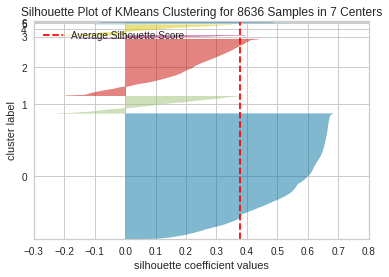

For 8 clusters, Silhouette score is 0.3897


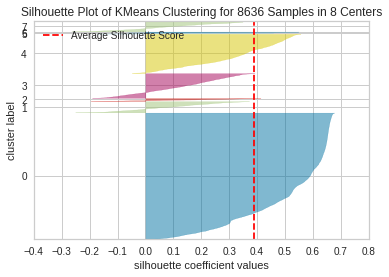

In [21]:
# creating silhoette plot using K-means scoring : no good silhoutte plot observed
silhoutte_plot(df_all_columns[all_analysis_columns])
# because of no elbow-point and poor silhoutte plot, no cluster assigning for this dataset

### 3.2 Analysis on the Original Dataset with log-norm transformation 

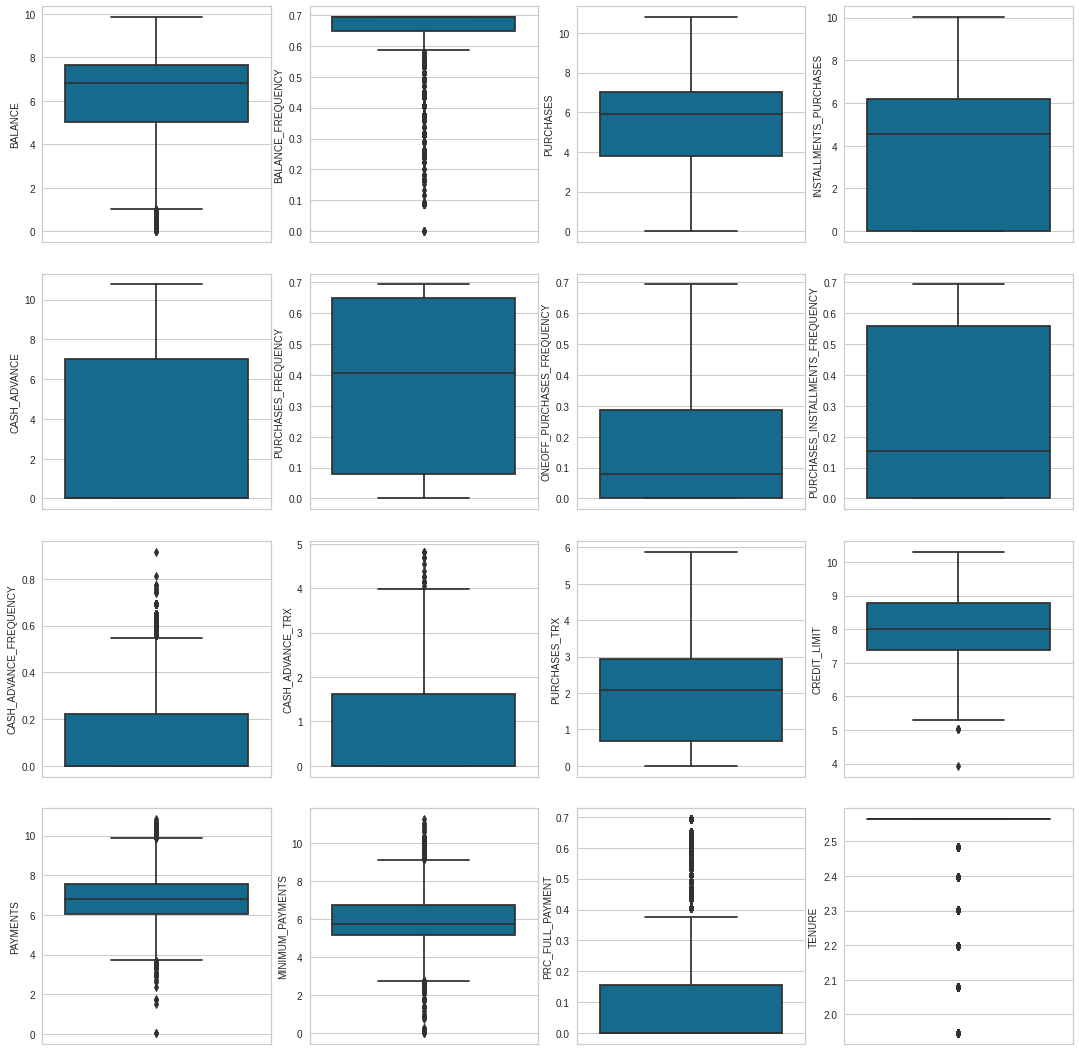

In [22]:
box_plot(df_all_columns_log)
# After log-normalization, very few variables have a skewed distribution

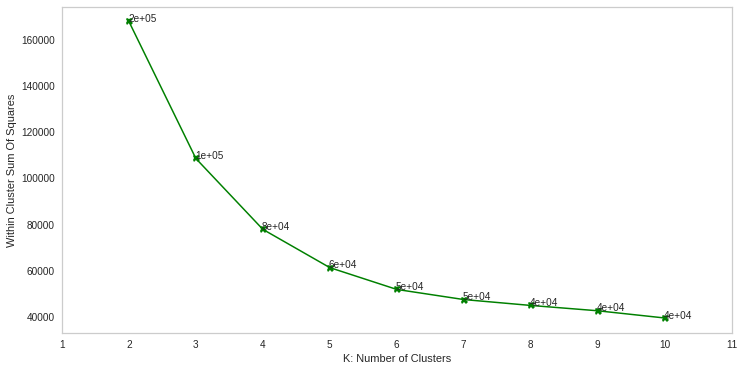

In [23]:
# creating elbow plot : 'elbow-point' for 3 to 5 clusters observed 
elbow_plot(df_all_columns_log[all_analysis_columns])

For 2 clusters, Silhouette score is 0.4173


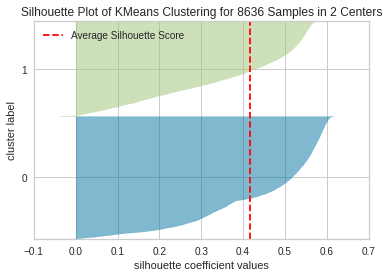

For 3 clusters, Silhouette score is 0.435


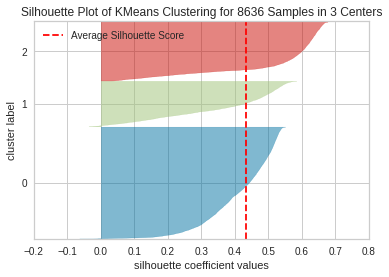

For 4 clusters, Silhouette score is 0.4323


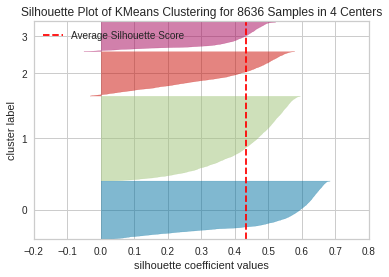

For 5 clusters, Silhouette score is 0.4284


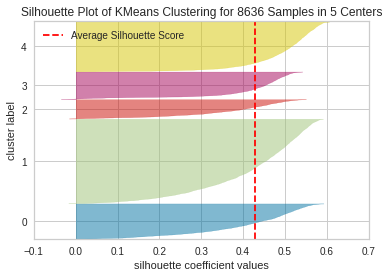

For 6 clusters, Silhouette score is 0.387


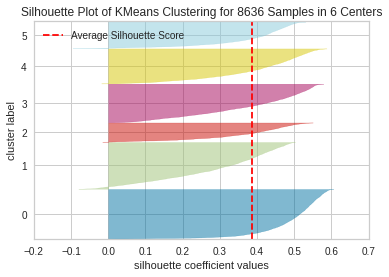

For 7 clusters, Silhouette score is 0.3399


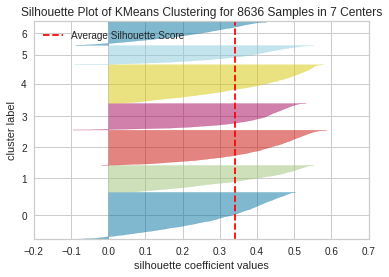

For 8 clusters, Silhouette score is 0.3226


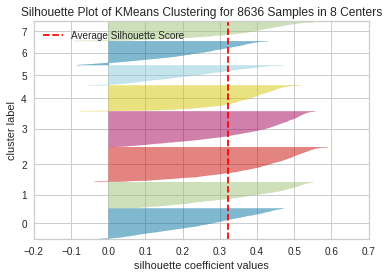

In [24]:
# creating silhoutte plot : best plot appears for 3 clusters
silhoutte_plot(df_all_columns_log[all_analysis_columns])

In [25]:
# assigning/fitting 3 clusters to this dataset

df_cluster = assign_cluster(df_all_columns_log, all_analysis_columns, 3)
df_cluster.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,C10001,3.735,0.598,4.569,4.569,0.000,0.154,0.000,0.080,0.000,0.000,1.099,6.909,5.312,4.945,0.000,2.565,0
1,C10002,8.072,0.647,0.000,0.000,8.771,0.000,0.000,0.000,0.223,1.609,0.000,8.854,8.320,6.979,0.201,2.565,2
2,C10003,7.823,0.693,6.652,0.000,0.000,0.693,0.693,0.000,0.000,0.000,2.565,8.923,6.435,6.443,0.000,2.565,0
4,C10005,6.708,0.693,2.833,0.000,0.000,0.080,0.080,0.000,0.000,0.000,0.693,7.091,6.521,5.504,0.000,2.565,0
5,C10006,7.502,0.693,7.196,7.196,0.000,0.511,0.000,0.460,0.000,0.000,2.197,7.496,7.245,7.787,0.000,2.565,0


,"(BALANCE, mean)","(BALANCE, std)","(BALANCE, min)","(BALANCE, max)","(BALANCE_FREQUENCY, mean)","(BALANCE_FREQUENCY, std)","(BALANCE_FREQUENCY, min)","(BALANCE_FREQUENCY, max)","(PURCHASES, mean)","(PURCHASES, std)","(PURCHASES, min)","(PURCHASES, max)","(INSTALLMENTS_PURCHASES, mean)","(INSTALLMENTS_PURCHASES, std)","(INSTALLMENTS_PURCHASES, min)","(INSTALLMENTS_PURCHASES, max)","(CASH_ADVANCE, mean)","(CASH_ADVANCE, std)","(CASH_ADVANCE, min)","(CASH_ADVANCE, max)","(PURCHASES_FREQUENCY, mean)","(PURCHASES_FREQUENCY, std)","(PURCHASES_FREQUENCY, min)","(PURCHASES_FREQUENCY, max)","(ONEOFF_PURCHASES_FREQUENCY, mean)","(ONEOFF_PURCHASES_FREQUENCY, std)","(ONEOFF_PURCHASES_FREQUENCY, min)","(ONEOFF_PURCHASES_FREQUENCY, max)","(PURCHASES_INSTALLMENTS_FREQUENCY, mean)","(PURCHASES_INSTALLMENTS_FREQUENCY, std)","(PURCHASES_INSTALLMENTS_FREQUENCY, min)","(PURCHASES_INSTALLMENTS_FREQUENCY, max)","(CASH_ADVANCE_FREQUENCY, mean)","(CASH_ADVANCE_FREQUENCY, std)","(CASH_ADVANCE_FREQUENCY, min)","(CASH_ADVANCE_FREQUENCY, max)","(CASH_ADVANCE_TRX, mean)","(CASH_ADVANCE_TRX, std)","(CASH_ADVANCE_TRX, min)","(CASH_ADVANCE_TRX, max)","(PURCHASES_TRX, mean)","(PURCHASES_TRX, std)","(PURCHASES_TRX, min)","(PURCHASES_TRX, max)","(CREDIT_LIMIT, mean)","(CREDIT_LIMIT, std)","(CREDIT_LIMIT, min)","(CREDIT_LIMIT, max)","(PAYMENTS, mean)","(PAYMENTS, std)","(PAYMENTS, min)","(PAYMENTS, max)","(MINIMUM_PAYMENTS, mean)","(MINIMUM_PAYMENTS, std)","(MINIMUM_PAYMENTS, min)","(MINIMUM_PAYMENTS, max)","(PRC_FULL_PAYMENT, mean)","(PRC_FULL_PAYMENT, std)","(PRC_FULL_PAYMENT, min)","(PRC_FULL_PAYMENT, max)","(TENURE, mean)","(TENURE, std)","(TENURE, min)","(TENURE, max)",Count
0,5.343,1.899,0.000,9.855,0.611,0.145,0.000,0.693,6.415,1.326,0.010,10.623,4.634,2.712,0.000,10.021,0.030,0.331,0.000,5.207,0.493,0.213,0.080,0.693,0.203,0.237,0.000,0.693,0.379,0.269,0.000,0.693,0.001,0.008,0.000,0.201,0.006,0.067,0.000,1.099,2.526,1.001,0.000,5.883,8.075,0.819,5.017,10.309,6.632,1.147,0.055,10.834,5.489,1.111,0.019,11.244,0.195,0.256,0.000,0.693,2.532,0.112,1.946,2.565,4467
1,7.465,1.096,1.558,9.699,0.673,0.060,0.167,0.693,6.697,1.088,2.963,10.800,4.690,2.648,0.000,9.595,7.008,1.280,2.986,10.761,0.497,0.194,0.080,0.693,0.242,0.217,0.000,0.693,0.366,0.261,0.000,0.693,0.245,0.154,0.080,0.811,1.768,0.816,0.693,4.820,2.688,0.931,0.693,5.852,8.308,0.805,5.707,10.309,7.345,1.056,3.524,10.756,6.609,1.043,2.762,10.369,0.053,0.126,0.000,0.693,2.516,0.136,1.946,2.565,1819
2,7.091,1.419,0.001,9.588,0.639,0.117,0.087,0.693,0.735,1.708,0.000,6.176,0.012,0.189,0.000,4.219,6.827,1.407,0.000,10.173,0.020,0.056,0.000,0.693,0.019,0.054,0.000,0.693,0.001,0.016,0.000,0.651,0.234,0.146,0.000,0.916,1.668,0.768,0.000,4.820,0.160,0.393,0.000,2.639,7.985,0.813,3.932,9.852,6.752,1.138,0.048,10.437,6.216,1.099,0.111,11.019,0.037,0.103,0.000,0.693,2.505,0.145,1.946,2.565,2350


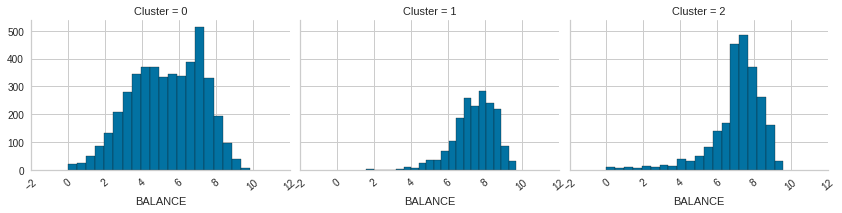

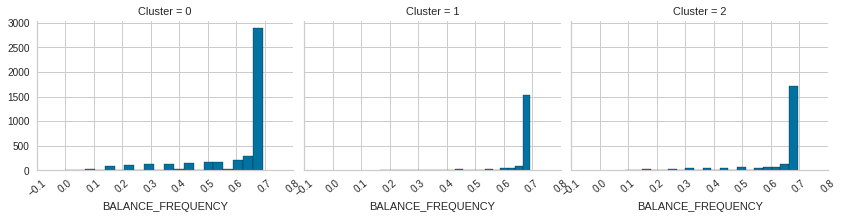

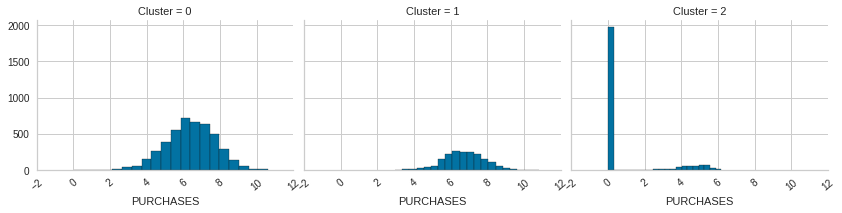

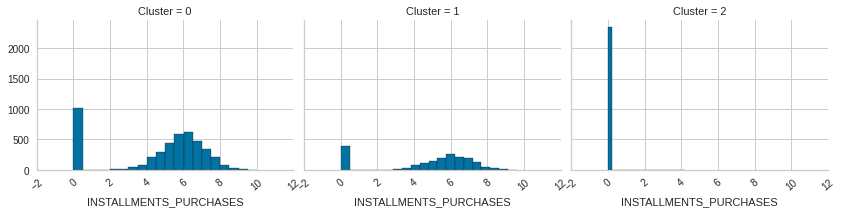

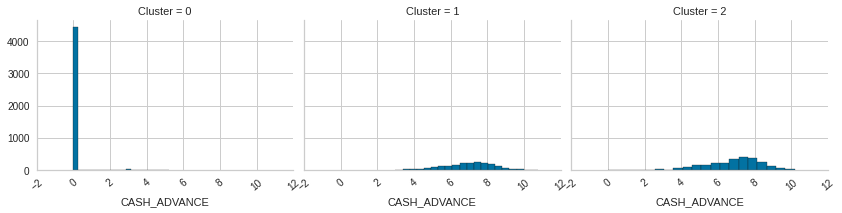

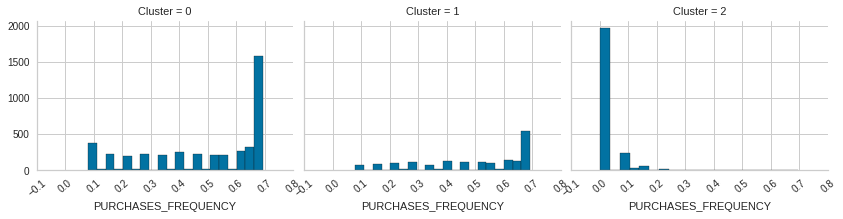

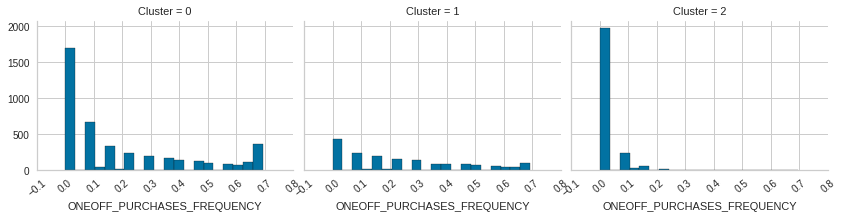

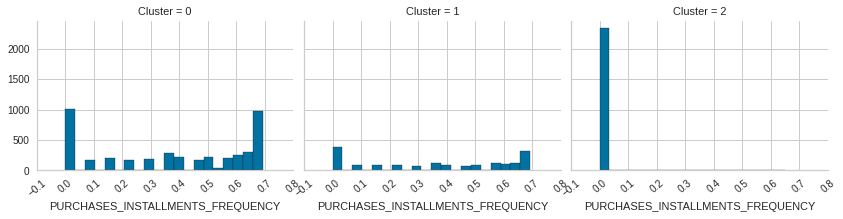

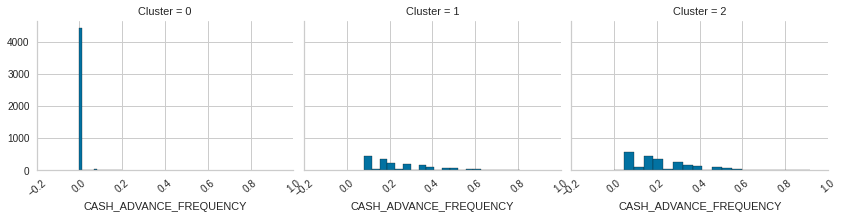

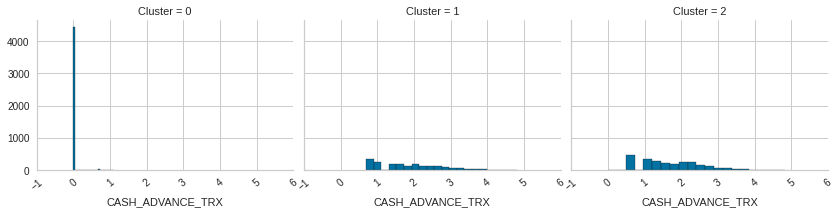

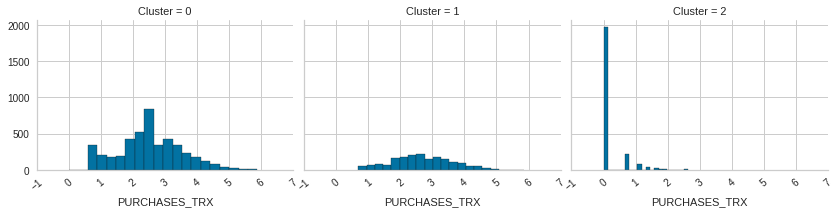

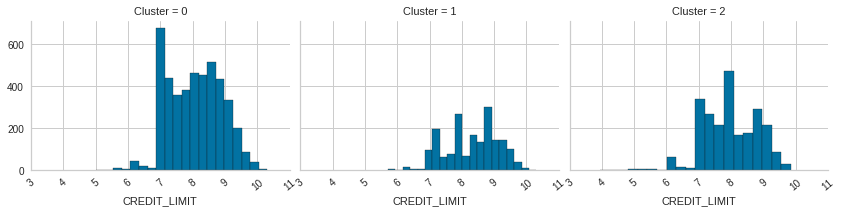

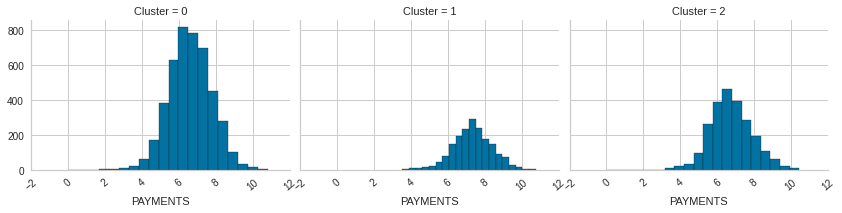

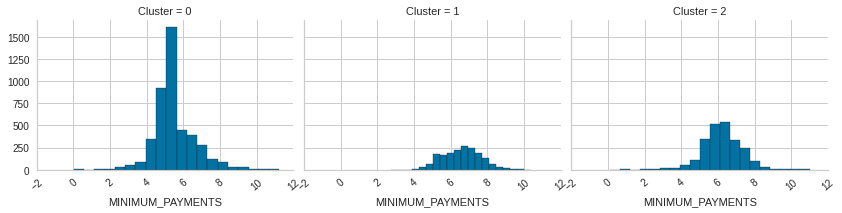

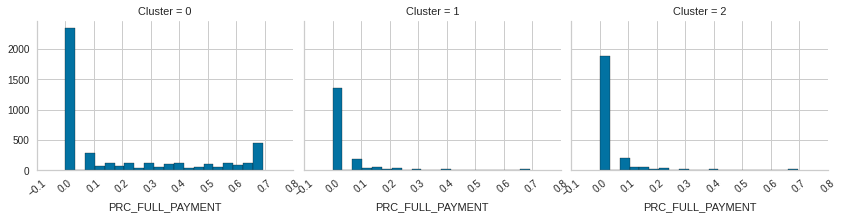

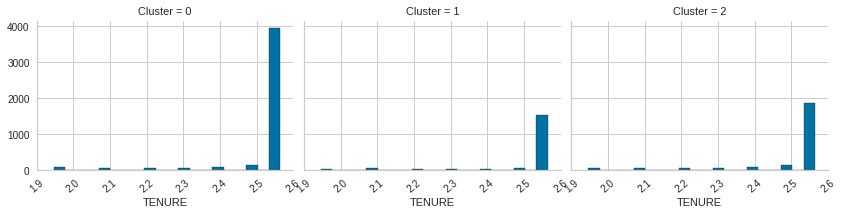

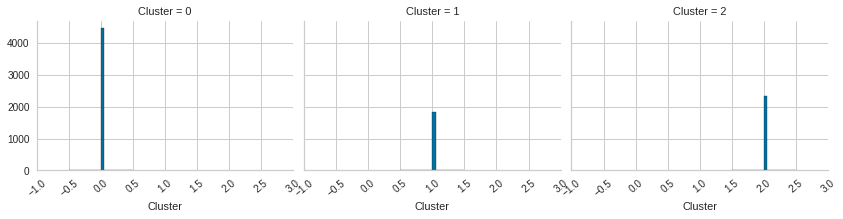

In [26]:
# summary statistics for each cluster

df_cluster_stats = cluster_statistics(df_cluster)
df_cluster_stats

In [27]:
# collecting labels for each of the 3 clusters
label_array = df_cluster[['Cluster']].values

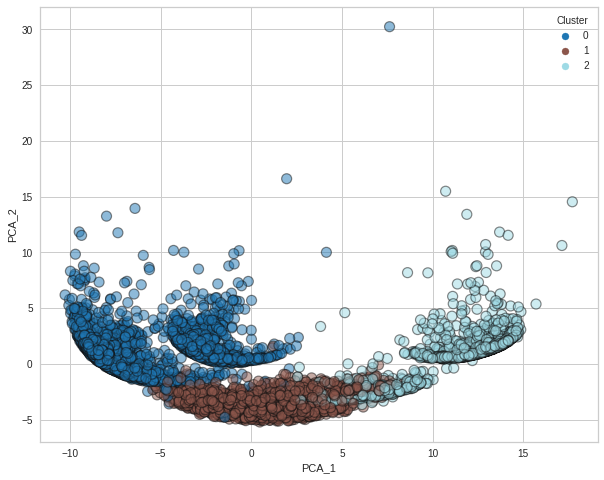

In [28]:
plot_2d(df_all_columns_log[all_analysis_columns], label_array)

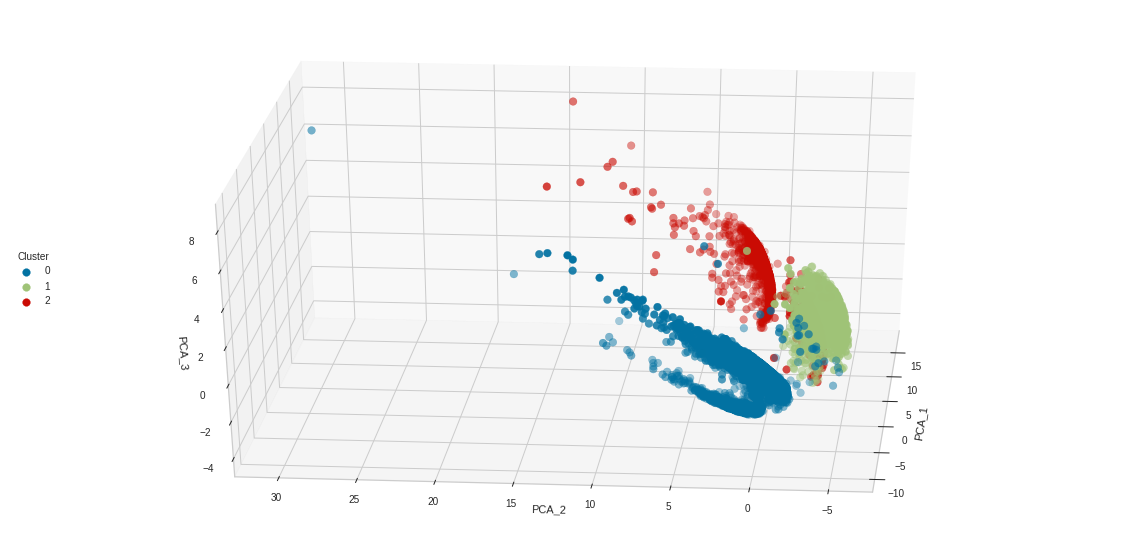

In [29]:
plot_3d(df_all_columns_log[all_analysis_columns], label_array)

### 3.3 Analysis on Dataset with Significant Variables

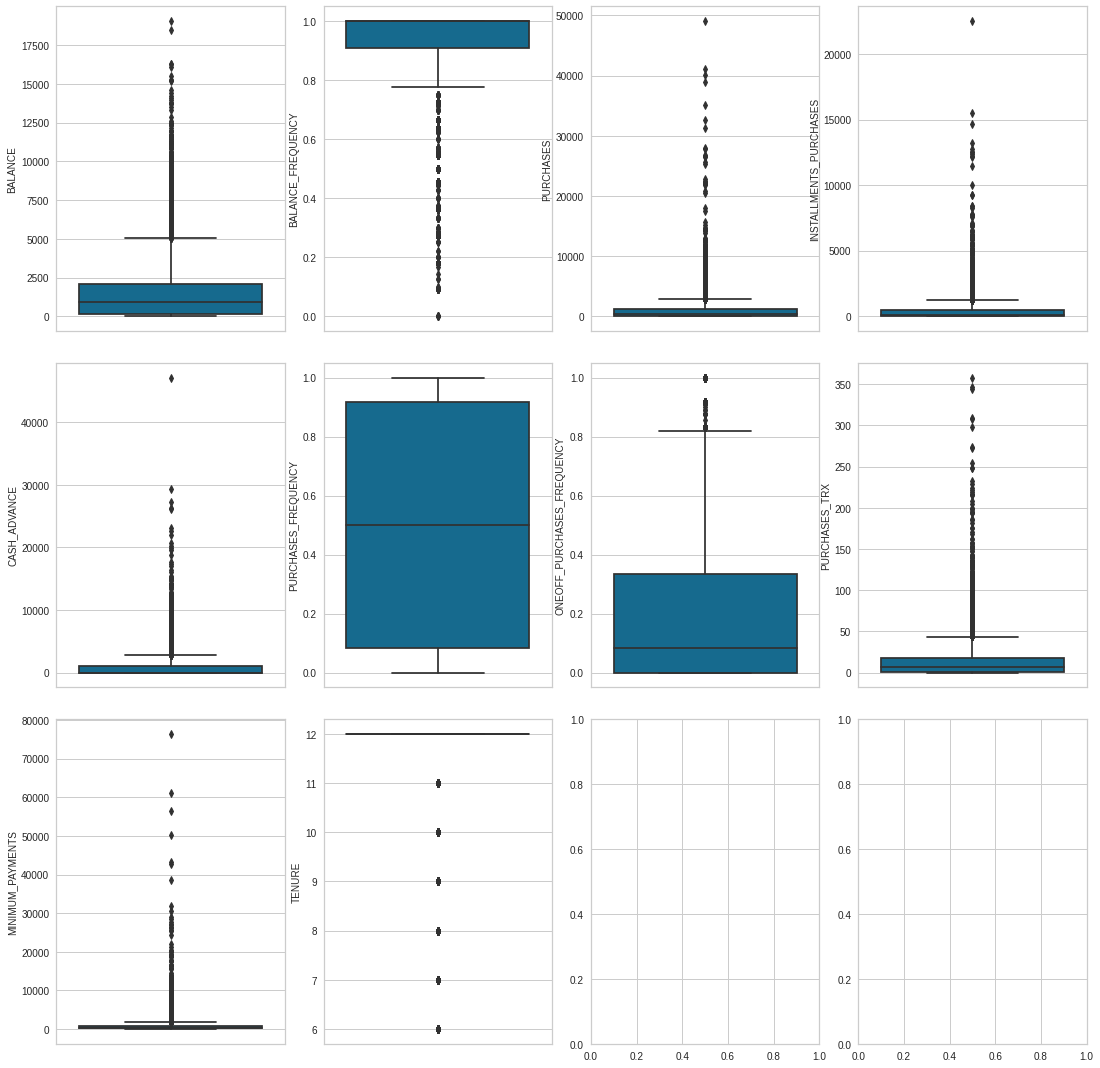

In [30]:
box_plot(df_selected_columns)
# It can be observed that a lot of variabels have a skewed distribution.

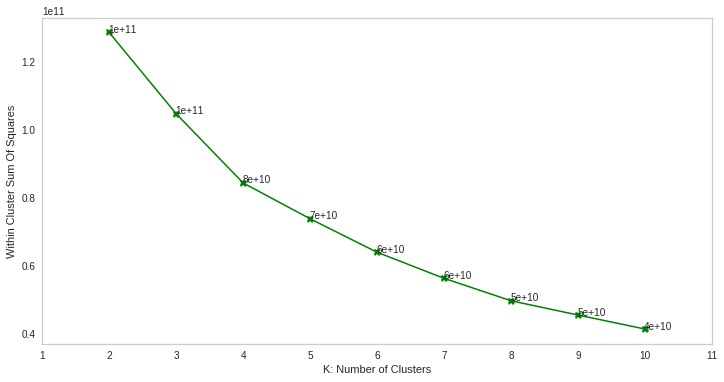

In [31]:
# creating elbow plot using K-means scoring : no elbow-point observed
elbow_plot(df_selected_columns)

For 2 clusters, Silhouette score is 0.6179


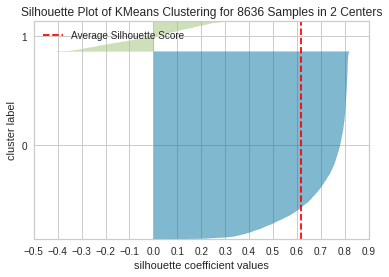

For 3 clusters, Silhouette score is 0.5852


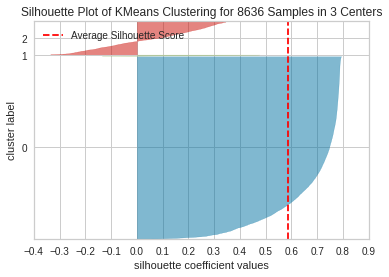

For 4 clusters, Silhouette score is 0.5869


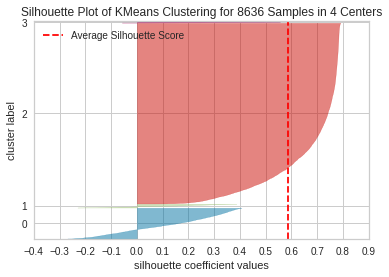

For 5 clusters, Silhouette score is 0.5316


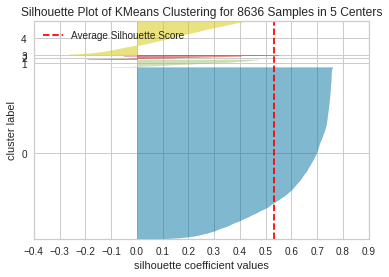

For 6 clusters, Silhouette score is 0.5297


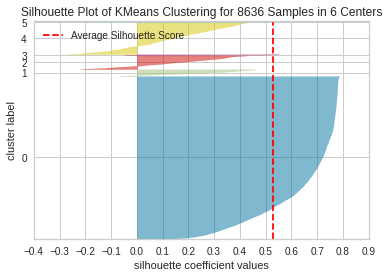

For 7 clusters, Silhouette score is 0.5287


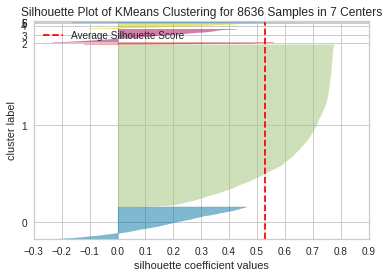

For 8 clusters, Silhouette score is 0.4343


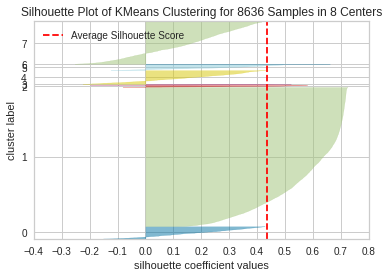

In [32]:
# creating silhoutte-plot using K-means scoring : no good silhoutte-plot observed
silhoutte_plot(df_selected_columns[selected_analysis_columns])
# no cluster assigning/fitting fot this dataset

### 3.4 Analysis on Dataset with Log-Normalised Significant Variables

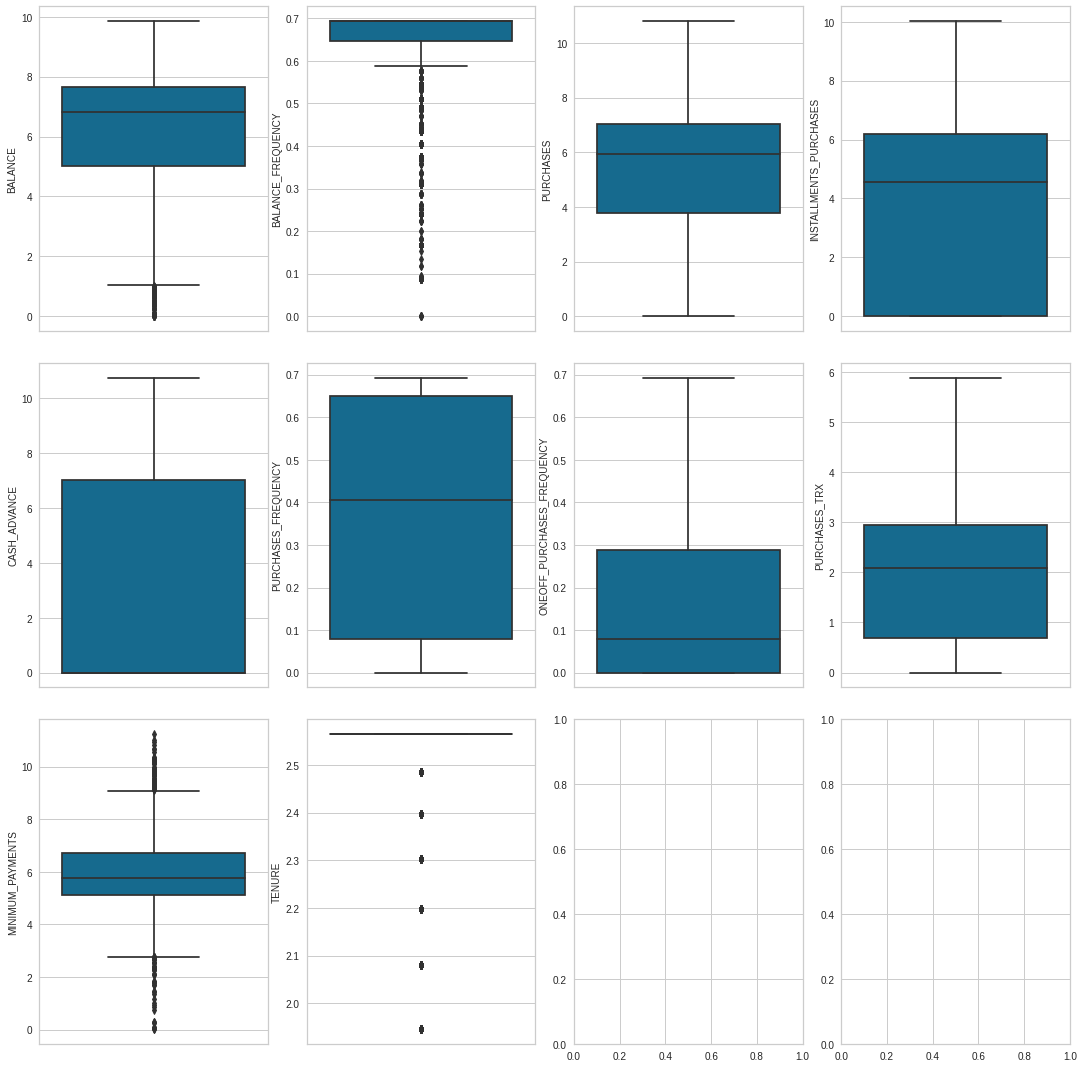

In [33]:
box_plot(df_selected_columns_log)
# skewness lowered after log-norm transform

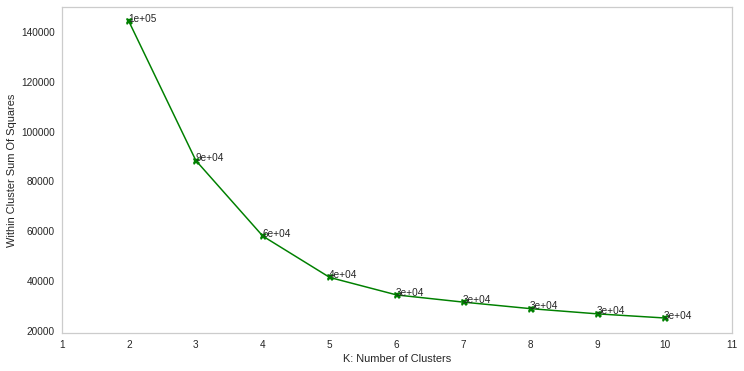

In [34]:
# creating elbow-plot using k-means scoring : 'elbow-point' observed for clusters 3 to 5 clusters
elbow_plot(df_selected_columns_log[selected_analysis_columns])

For 2 clusters, Silhouette score is 0.4477


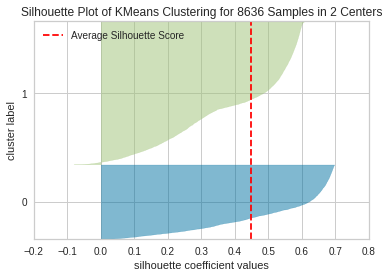

For 3 clusters, Silhouette score is 0.4682


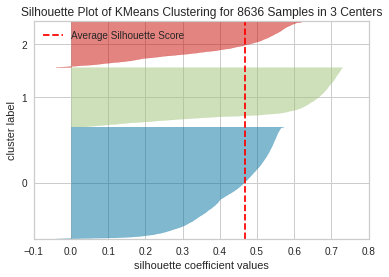

For 4 clusters, Silhouette score is 0.4799


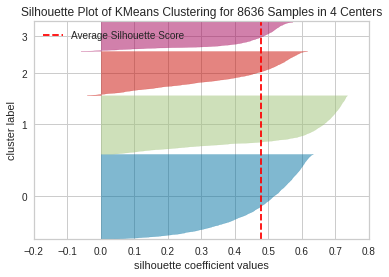

For 5 clusters, Silhouette score is 0.4883


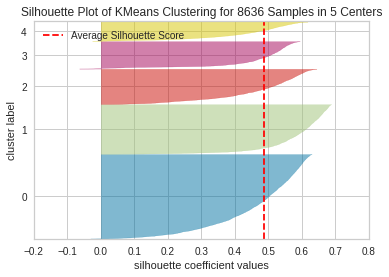

For 6 clusters, Silhouette score is 0.4447


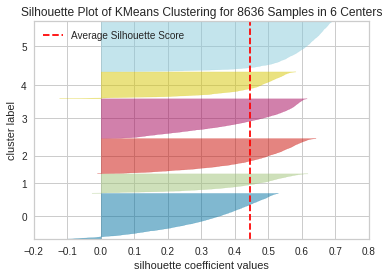

For 7 clusters, Silhouette score is 0.39


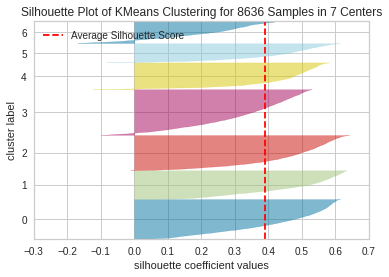

For 8 clusters, Silhouette score is 0.3733


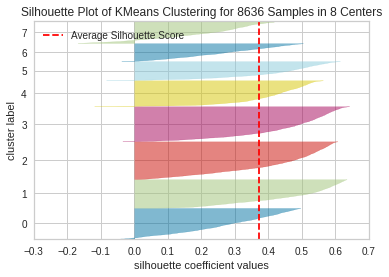

In [35]:
# creating silhoutte-plot using k-means scoring : 'elbow-point' observed for clusters 3-4-5 clusters
silhoutte_plot(df_selected_columns_log[selected_analysis_columns])

In [36]:
# fitting/assigning 3 clusters for this data 
df_cluster = assign_cluster(df_selected_columns_log, selected_analysis_columns, 3)
df_cluster.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,MINIMUM_PAYMENTS,TENURE,Cluster
0,C10001,3.735,0.598,4.569,4.569,0.000,0.154,0.000,1.099,4.945,2.565,0
1,C10002,8.072,0.647,0.000,0.000,8.771,0.000,0.000,0.000,6.979,2.565,1
2,C10003,7.823,0.693,6.652,0.000,0.000,0.693,0.693,2.565,6.443,2.565,0
4,C10005,6.708,0.693,2.833,0.000,0.000,0.080,0.080,0.693,5.504,2.565,0
5,C10006,7.502,0.693,7.196,7.196,0.000,0.511,0.000,2.197,7.787,2.565,0


,"(BALANCE, mean)","(BALANCE, std)","(BALANCE, min)","(BALANCE, max)","(BALANCE_FREQUENCY, mean)","(BALANCE_FREQUENCY, std)","(BALANCE_FREQUENCY, min)","(BALANCE_FREQUENCY, max)","(PURCHASES, mean)","(PURCHASES, std)","(PURCHASES, min)","(PURCHASES, max)","(INSTALLMENTS_PURCHASES, mean)","(INSTALLMENTS_PURCHASES, std)","(INSTALLMENTS_PURCHASES, min)","(INSTALLMENTS_PURCHASES, max)","(CASH_ADVANCE, mean)","(CASH_ADVANCE, std)","(CASH_ADVANCE, min)","(CASH_ADVANCE, max)","(PURCHASES_FREQUENCY, mean)","(PURCHASES_FREQUENCY, std)","(PURCHASES_FREQUENCY, min)","(PURCHASES_FREQUENCY, max)","(ONEOFF_PURCHASES_FREQUENCY, mean)","(ONEOFF_PURCHASES_FREQUENCY, std)","(ONEOFF_PURCHASES_FREQUENCY, min)","(ONEOFF_PURCHASES_FREQUENCY, max)","(PURCHASES_TRX, mean)","(PURCHASES_TRX, std)","(PURCHASES_TRX, min)","(PURCHASES_TRX, max)","(MINIMUM_PAYMENTS, mean)","(MINIMUM_PAYMENTS, std)","(MINIMUM_PAYMENTS, min)","(MINIMUM_PAYMENTS, max)","(TENURE, mean)","(TENURE, std)","(TENURE, min)","(TENURE, max)",Count
0,5.343,1.899,0.000,9.855,0.611,0.145,0.000,0.693,6.416,1.325,0.010,10.623,4.634,2.713,0.000,10.021,0.028,0.320,0.000,5.207,0.493,0.213,0.080,0.693,0.203,0.237,0.000,0.693,2.527,1.001,0.000,5.883,5.489,1.111,0.019,11.244,2.532,0.112,1.946,2.565,4465
1,7.098,1.418,0.001,9.588,0.640,0.116,0.087,0.693,0.759,1.736,0.000,6.176,0.013,0.198,0.000,4.219,6.832,1.412,0.000,10.173,0.021,0.057,0.000,0.693,0.020,0.055,0.000,0.693,0.165,0.400,0.000,2.639,6.221,1.098,0.111,11.019,2.506,0.145,1.946,2.565,2363
2,7.457,1.101,1.558,9.699,0.673,0.061,0.167,0.693,6.706,1.087,2.963,10.800,4.720,2.628,0.000,9.595,6.999,1.278,2.986,10.761,0.499,0.192,0.080,0.693,0.242,0.218,0.000,0.693,2.698,0.925,0.693,5.852,6.603,1.047,2.762,10.369,2.516,0.137,1.946,2.565,1808


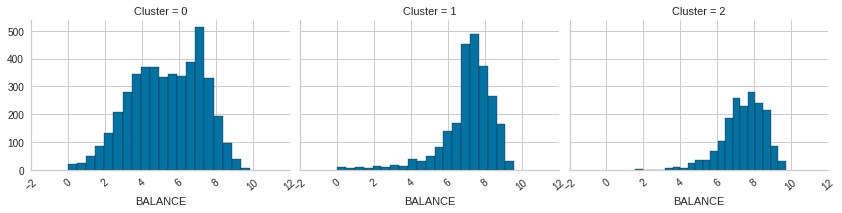

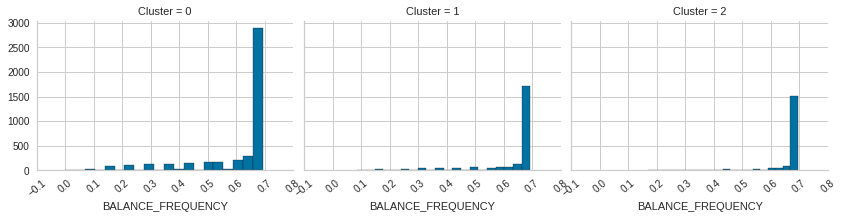

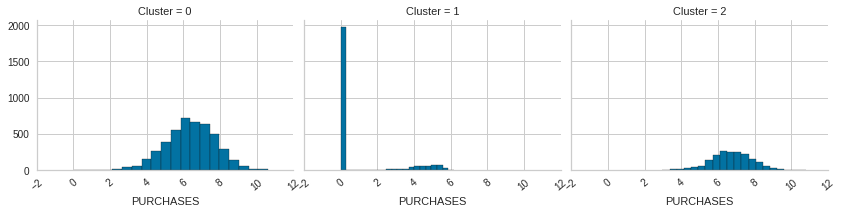

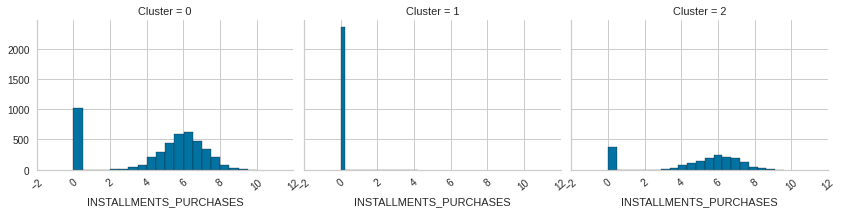

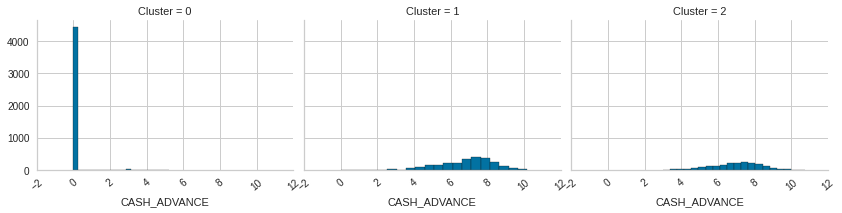

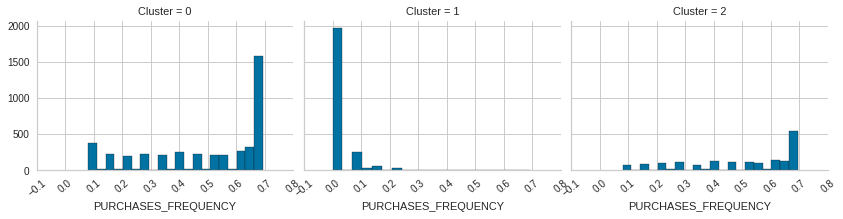

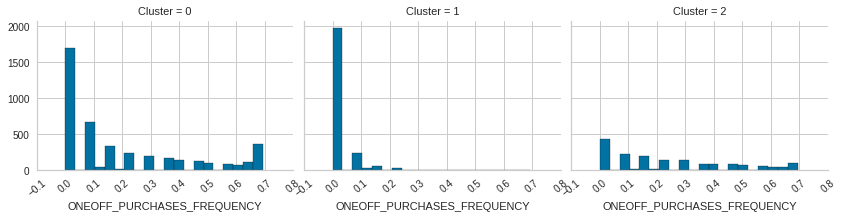

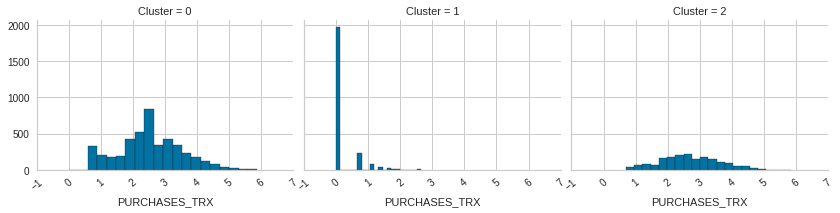

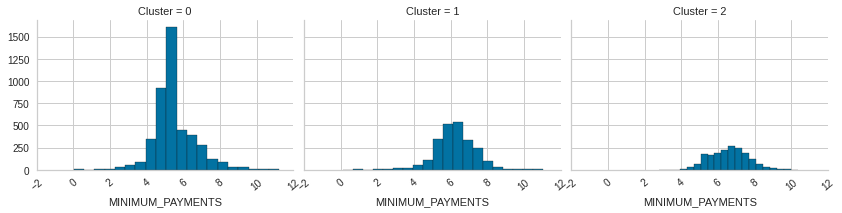

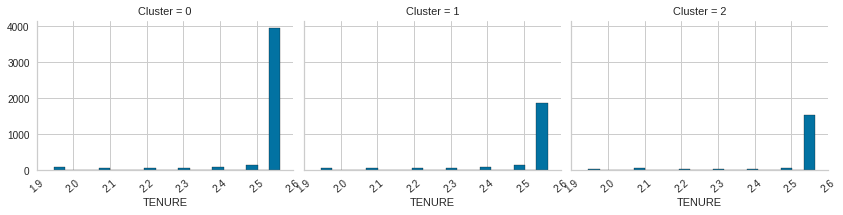

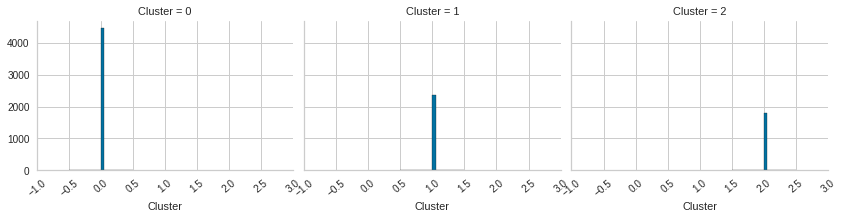

In [37]:
# summary statistics for each cluster

df_cluster_stats = cluster_statistics(df_cluster)
df_cluster_stats

In [38]:
label_array = df_cluster[['Cluster']].values

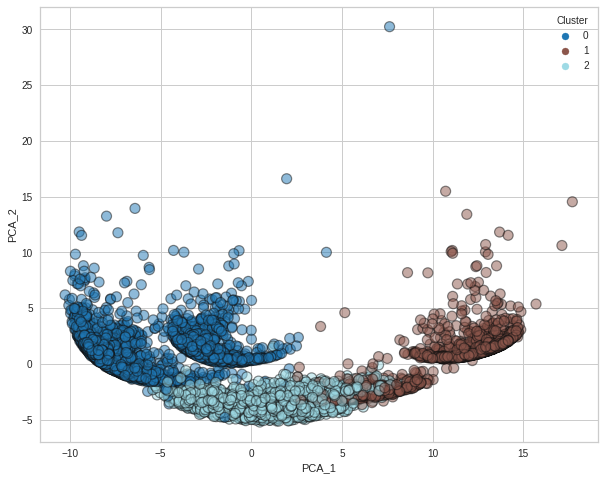

In [39]:
plot_2d(df_all_columns_log[all_analysis_columns], label_array)

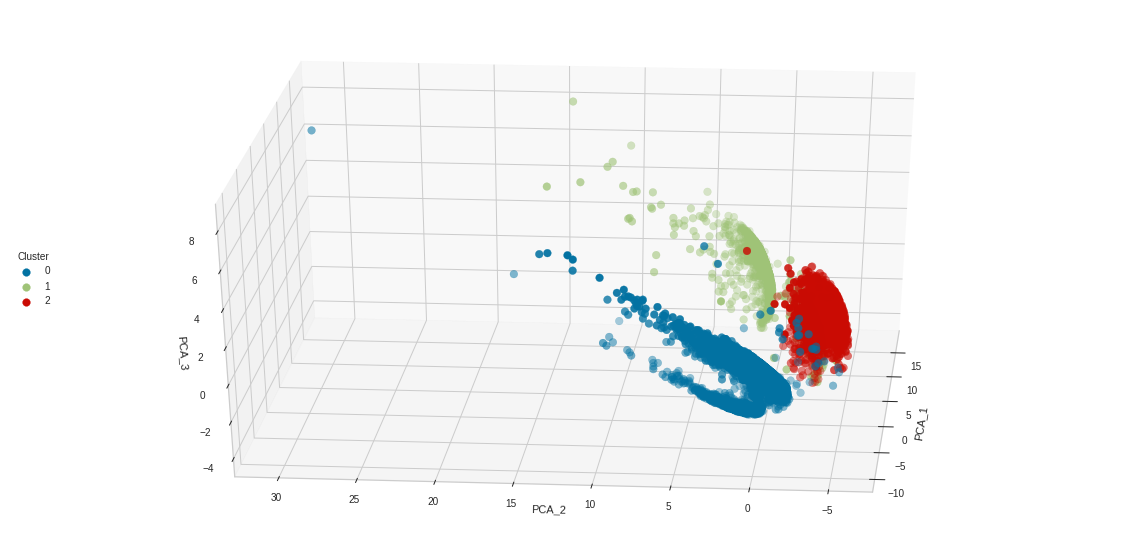

In [40]:
plot_3d(df_all_columns_log[all_analysis_columns], label_array)

Comparing the results of all 4 analyses, Clusters obtained from Log-normalization transformation on the dataset with significant variables seem more clear-cut and prominent. Therefore, lets go ahead with the 3 clusters from the 4th analysis

Taking 3 Clusters now :

Cluster 0 : Biggest Cluster, around 4500 customers.
Customer Profile : Regular Customers that have average to high Credit limit, who like to purchase things regularly, often in installments and less often with cash in advance (Purchase frequency is relatively high and purchase amount is relatively lower). In general they reach credit limit. 
Strategy : This group is good to target for regular products/partners promotion deals : Low Margins, High Frequency

Cluster 1 :
Medium sized Cluster, around 2300 customers.
Customer Profile : Customers that have average Credit limit, who don't prefer to use credit card often. Purchase frequency is low, and they prefer to purchase with cash in advance than in installments. In general they don't reach credit limit.
Strategy : Further analysis on this group to check its preference and spend behaviour : Debit Card or other modes of purchases.

Cluster 2 : Smallest Cluster, around 1800 customers.
Customer Profile : Customers that mostly have high Credit limit, who like to purchase things regularly, with mostly payments in advance, but with substantial puchases in installments at the same time (Purchase frequency is relatively high and purchase amount is relatively higher). In general they don't reach credit limit. 
Strategy : This group is good to target for high-end/luxury products/partners promotion deals : High Margins, Low Frequency